### Calculate the policy of the agent
* State Variable: x = [w, n, e, s, A], action variable a = [c, b, k], both of them are numpy array 

In [10]:
%pylab inline
from scipy.interpolate import interpn
from helpFunctions import surfacePlot
import numpy as np
from scipy import optimize
from multiprocessing import Pool
from functools import partial
import warnings
warnings.filterwarnings("ignore")
np.printoptions(precision=2)

# time line
T_min = 0
T_max = 70
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
r_f = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
# r_m = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_m = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1

#Define the utility function
def u(c):
    gamma = 2
    # minimum consumption
    c_bar = 3
    return (np.float_power(max(c-c_bar,0),1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(w):
    B = 2
    return B*u(w+c_bar+1)

#Define the earning function, which applies for both employment and unemployment
def y(t, x):
    w, n, e, s, A = x
    if A == 0:
        return 0
    else:
        if t < T_R:
            return detEarning[t] * earningShock[int(s)] * e + (1-e) * 5
        else:
            return detEarning[t]

# Define the reward funtion depends on both state and action.
def R(x, a):
    c, b, k = a
    w, n, e, s, A = x
    if A == 0:
        return uB(w+(1+r_bar)*n)
    else:
        return u(c)
    
# Define the transition of state
def transition(x, a, t):
    '''
         Input: x current state: (w, n, s, e, A)
                a action taken: (c, b, k)
         Output: the next possible states with corresponding probabilities
    '''
    # unpack variable
    c, b, k = a
    w, n, e, s, A = x
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    # Agent is dead at the end of last period
    if A == 0:
        for s_next in [0,1]:
            x_next.append([0, 0, s_next, 0, 0])
        return np.array(x_next), Ps[int(s)]
    # Agent is alive
    else:
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        Pat = [1-Pa[t], Pa[t]]
        r_bond = r_f[int(s)]
        # calcualte n_next
        if t < T_R:
            # before retirement agents put 5% of income to 401k
            if e == 1:
                n_next = (n+0.05*y(t,x))*(1+r_bar)
            else:
                n_next = n*(1+r_bar)
   
            # for potential s_next, e_next and A_next
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for e_next in [0,1]:
                    for A_next in [0,1]:
                        x_next.append([w_next, n_next, s_next, e_next, A_next])
                        prob_next.append(Ps[int(s),s_next] * Pat[A_next] * Pe[int(s),s_next,int(e),e_next])

        else:
            # after retirement agents withdraw cash from 401k
            n_next = n*(1+r_bar)-n/discounting
            e_next = 0
   
            # for potential s_next and A_next
            for s_next in [0, 1]:
                r_stock = r_m[int(s), s_next]
                w_next =  b*(1+r_bond) + k*(1+r_stock)
                for A_next in [0,1]:
                    x_next.append([w_next, n_next, s_next, e_next, A_next])
                    prob_next.append(Pat[A_next] * Ps[int(s), s_next])

    return np.array(x_next), np.array(prob_next)

# Value function is a function of state and time t
def V(x, t, points, Vgrid):
    # Define the objective function as a function of action
    w, n, e, s, A = x
    if A == 0:
        return np.array([R(x,[0,0,0]),[0,0,0]])
    else: 
        # variables needed
        N = np.sum(Pa[t:])
        discounting = ((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)
        n_discount = n/discounting
        ytx = y(t, x)
        
        def obj(thetaTheta):
            theta1,theta2 = thetaTheta
            if t < T_R:
                if e == 1:
                    bk = ((1-tau_L)*(ytx * 0.95) + w) * theta1
                    c = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1)
                else:
                    bk = ((1-tau_L)*ytx + w) * theta1
                    c = ((1-tau_L)*ytx + w) * (1-theta1)
            else:
                bk = ((1-tau_R)*ytx + w + n_discount) * theta1
                c = ((1-tau_R)*ytx + w + n_discount) * (1-theta1)
            b = bk * theta2
            k = bk * (1-theta2)
            a = (c,b,k)
            x_next, prob_next = transition(x, a, t)
            
            V_tilda = []
            for xx in x_next:
                V_tilda.append(interpn(points, Vgrid[:,:,int(xx[2]),int(xx[3]),int(xx[4]),t+1], xx[:2], 
                                       bounds_error = False, fill_value = None)[0])
            return -(R(x, a) + beta * np.dot(V_tilda, prob_next))
        
        res = optimize.minimize(obj, [0.5, 0.5], method="SLSQP",bounds = ((0, 1), (0, 1)), tol = 1e-9)
        xopt = res.x
        max_val = -res.fun
        theta1_m, theta2_m = xopt
        
        if t < T_R:
            if e == 1:
                bk_m = ((1-tau_L)*(ytx * 0.95) + w) * theta1_m
                c_m = ((1-tau_L)*(ytx * 0.95) + w) * (1-theta1_m)
            else:
                bk_m = ((1-tau_L)*ytx + w) * theta1_m
                c_m = ((1-tau_L)*ytx + w) * (1-theta1_m)
        else:
            bk_m = ((1-tau_R)*ytx + w + n_discount) * theta1_m
            c_m = ((1-tau_R)*ytx + w + n_discount) * (1-theta1_m)
        b_m = bk_m * theta2_m
        k_m = bk_m * (1-theta2_m)
        return np.array([max_val, [c_m, b_m, k_m]])

Populating the interactive namespace from numpy and matplotlib


In [11]:
# wealth discretization 
w_grid_size = 10
w_lower = 3
w_upper = 2000
# 401k amount discretization 
n_grid_size = 5
n_lower = 3
n_upper = 1000
power = 2

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)

# initialize the state discretization 
x_T = np.array([[w,n,e,s,0]   for w in powspace(w_lower, w_upper, power, w_grid_size)
                            for n in powspace(n_lower, n_upper, power, n_grid_size)
                            for e in [0,1]
                            for s in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

xgrid = np.array([[w,n,e,s,A] for w in powspace(w_lower, w_upper, power, w_grid_size)
                            for n in powspace(n_lower, n_upper, power, n_grid_size)
                            for e in [0,1]
                            for s in [0,1]
                            for A in [0,1]]).reshape((w_grid_size, n_grid_size, 2,2,2,5))

Vgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
cgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
bgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))
kgrid = np.zeros((w_grid_size, n_grid_size, 2, 2, 2, T_max+1))

# apply function to state space, need to reshape the matrix and shape it back to the size
def applyFunToCalculateValue(fun, x = x_T):
    return np.array(list(map(fun, x.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))))).reshape((w_grid_size, n_grid_size, 2,2,2))

Vgrid[:,:,:,:,:, T_max] = applyFunToCalculateValue(partial(R, a = [0,0,0]), x = x_T)

In [12]:
%%time 
ws = powspace(w_lower, w_upper, power, w_grid_size)
ns = powspace(n_lower, n_upper, power, n_grid_size)
points = (ws,ns)

xs = xgrid.reshape((w_grid_size * n_grid_size * 2 * 2 * 2, 5))

pool = Pool()

for t in range(T_max-1, -1, -1):
    print(t)  
    f = partial(V, t = t, points = points, Vgrid = Vgrid)
    results = np.array(pool.map(f, xs))
    Vgrid[:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size, 2,2,2))
    cgrid[:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    bgrid[:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
    kgrid[:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size, n_grid_size,2,2,2))
pool.close()

69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
CPU times: user 4.93 s, sys: 1.82 s, total: 6.76 s
Wall time: 3min 11s


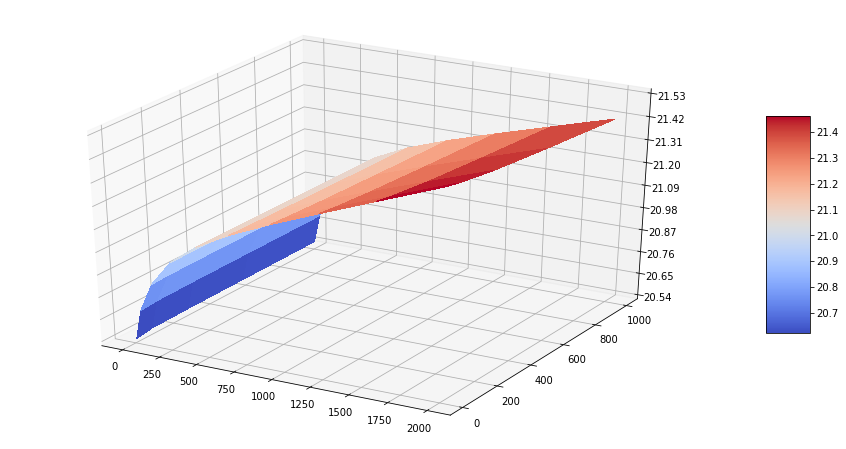

In [13]:
surfacePlot(xgrid[:,:,1,1,1,0], xgrid[:,:,1,1,1,1], Vgrid[:,:,1,1,1,t])

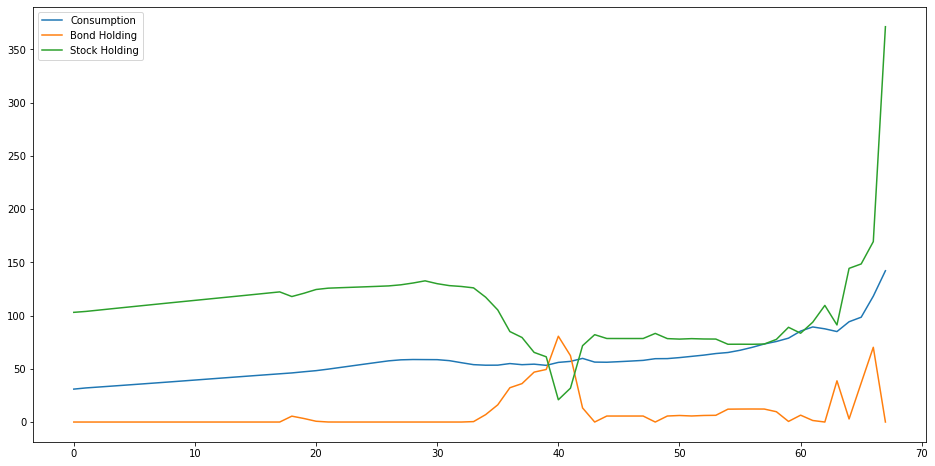

In [14]:
def summaryPlotChoiceVStime(w_level, n_level, s, e, A, C = cgrid, B = bgrid, K = kgrid):
    fig = plt.figure(figsize = [16,8])
    c = []
    b = []
    k = []
    for t in range(1,T_max-1):
        c.append(interpn((ws, ns), C[:,:,e,s,A,t],[w_level, n_level])[0])
        b.append(interpn((ws, ns), B[:,:,e,s,A,t],[w_level, n_level])[0])
        k.append(interpn((ws, ns), K[:,:,e,s,A,t],[w_level, n_level])[0])
    plt.plot(c, label = "Consumption")
    plt.plot(b, label= "Bond Holding")
    plt.plot(k, label="Stock Holding")
    plt.legend()
    plt.show()
summaryPlotChoiceVStime(100, 100, 1, 1, 1)